## Kotlin Notebooks<img src="https://plugins.jetbrains.com/files/16340/601949/icon/pluginIcon.svg" width="100" height="100">
### Define imports



In [1]:
%useLatestDescriptors
%use dataframe

%trackExecution generated
%use lib-ext(0.11.0-398)


### Explore the data

In [2]:
import org.jetbrains.kotlinx.dataframe.codeGen.generateCode
import org.jetbrains.kotlinx.dataframe.codeGen.generateInterfaces

val df = DataFrame.read("/Users/urs/development/github/ai/kotlin-ai-talk/langchain4j/src/main/resources/dataset/burglaries_ny_finance_district.csv", delimiter = ';')
df.head()

Datetime,Latitude,Longitude,Neighborhood,TypeOfProperty,PropertyValue,AmountStolen,CategoryOfItemsStolen,Temperature,ArrestMade
2024-08-02T02:21:18,"407032457,000000","-740950441,000000",Downtown,apartment,22925,3113,jewelry,8.60°C,false
2024-08-02T19:45:18,"407104848,000000","-741569801,000000",Downtown,restaurant,141,102,food,22.04°C,true
2024-08-03T12:09:08,"40705498,000000","-74007364,000000",Downtown,restaurant,295,40,food,10.47°C,true
2024-08-04T12:55:49,"407095008,000000","-740126642,000000",Downtown,restaurant,1789,31,food,18.14°C,true
2024-08-05T07:24:12,"407062008,000000","-740938172,000000",Downtown,restaurant,204,30,food,28.28°C,false


In [3]:
df.describe()

name,type,count,unique,nulls,top,freq,mean,std,min,median,max
Datetime,LocalDateTime,76,68,0,2024-08-28T01:53:52,4,null,null,2024-08-02T02:21:18,2024-08-19T09:15:43,2024-08-30T07:23:32
Latitude,Double,76,44,0,"407062008,000000",11,"358866014,105263","124665438,465258","40705498,000000","407062008,000000","407141495,000000"
Longitude,Double,76,44,0,"-740938172,000000",11,"-660379091,092105","219203858,534952","-741569801,000000","-740094006,000000","-7401048,000000"
Neighborhood,String,76,1,0,Downtown,76,null,null,Downtown,Downtown,Downtown
TypeOfProperty,String,76,5,0,restaurant,50,null,null,apartment,restaurant,shop
PropertyValue,Int,76,46,0,231,9,"47557,105263","104407,240150",70,1348,546172
AmountStolen,Int,76,48,0,78,8,"7243,197368","16905,635555",19,134,88237
CategoryOfItemsStolen,String,76,5,0,food,51,null,null,art,food,jewelry
Temperature,String,76,36,0,28.28°C,11,null,null,-3.60°C,22.85°C,8.60°C
ArrestMade,Boolean,76,2,0,false,60,null,null,false,false,true


In [6]:
df.select("ArrestMade", "Datetime", "AmountStolen", "CategoryOfItemsStolen", "TypeOfProperty")

ArrestMade,Datetime,AmountStolen,CategoryOfItemsStolen,TypeOfProperty
false,2024-08-02T02:21:18,3113,jewelry,apartment
true,2024-08-02T19:45:18,102,food,restaurant
true,2024-08-03T12:09:08,40,food,restaurant
true,2024-08-04T12:55:49,31,food,restaurant
false,2024-08-05T07:24:12,30,food,restaurant
false,2024-08-05T19:02:21,16162,cash,hotel
false,2024-08-08T03:01:56,65408,cash,industrial
true,2024-08-08T19:35:06,124,food,restaurant
true,2024-08-09T02:33:29,8626,cash,apartment
true,2024-08-10T07:22:13,19254,cash,shop


In [7]:
df.generateCode()


@DataSchema
interface _DataFrameType {
    val AmountStolen: kotlin.Int
    val ArrestMade: kotlin.Boolean
    val CategoryOfItemsStolen: kotlin.String
    val Datetime: kotlinx.datetime.LocalDateTime
    val Latitude: kotlin.Double
    val Longitude: kotlin.Double
    val Neighborhood: kotlin.String
    val PropertyValue: kotlin.Int
    val Temperature: kotlin.String
    val TypeOfProperty: kotlin.String
}

val org.jetbrains.kotlinx.dataframe.ColumnsContainer<_DataFrameType>.AmountStolen: org.jetbrains.kotlinx.dataframe.DataColumn<kotlin.Int> @JvmName("_DataFrameType_AmountStolen") get() = this["AmountStolen"] as org.jetbrains.kotlinx.dataframe.DataColumn<kotlin.Int>
val org.jetbrains.kotlinx.dataframe.DataRow<_DataFrameType>.AmountStolen: kotlin.Int @JvmName("_DataFrameType_AmountStolen") get() = this["AmountStolen"] as kotlin.Int
val org.jetbrains.kotlinx.dataframe.ColumnsContainer<_DataFrameType>.ArrestMade: org.jetbrains.kotlinx.dataframe.DataColumn<kotlin.Boolean> @JvmName("_Data

In [8]:
//
df.select { ArrestMade and Datetime and AmountStolen and CategoryOfItemsStolen and TypeOfProperty}


ArrestMade,Datetime,AmountStolen,CategoryOfItemsStolen,TypeOfProperty
false,2024-08-02T02:21:18,3113,jewelry,apartment
true,2024-08-02T19:45:18,102,food,restaurant
true,2024-08-03T12:09:08,40,food,restaurant
true,2024-08-04T12:55:49,31,food,restaurant
false,2024-08-05T07:24:12,30,food,restaurant
false,2024-08-05T19:02:21,16162,cash,hotel
false,2024-08-08T03:01:56,65408,cash,industrial
true,2024-08-08T19:35:06,124,food,restaurant
true,2024-08-09T02:33:29,8626,cash,apartment
true,2024-08-10T07:22:13,19254,cash,shop


In [9]:
import kotlinx.datetime.DayOfWeek

val dfExtra = df.add("DayOfWeek"){Datetime.dayOfWeek}.add("hourOfDay"){Datetime.hour}.add("Date"){Datetime.date}
dfExtra.generateCode()


@DataSchema
interface _DataFrameType {
    val AmountStolen: kotlin.Int
    val ArrestMade: kotlin.Boolean
    val CategoryOfItemsStolen: kotlin.String
    val Date: kotlinx.datetime.LocalDate
    val Datetime: kotlinx.datetime.LocalDateTime
    val DayOfWeek: java.time.DayOfWeek
    val Latitude: kotlin.Double
    val Longitude: kotlin.Double
    val Neighborhood: kotlin.String
    val PropertyValue: kotlin.Int
    val Temperature: kotlin.String
    val TypeOfProperty: kotlin.String
    val hourOfDay: kotlin.Int
}

val org.jetbrains.kotlinx.dataframe.ColumnsContainer<_DataFrameType>.AmountStolen: org.jetbrains.kotlinx.dataframe.DataColumn<kotlin.Int> @JvmName("_DataFrameType_AmountStolen") get() = this["AmountStolen"] as org.jetbrains.kotlinx.dataframe.DataColumn<kotlin.Int>
val org.jetbrains.kotlinx.dataframe.DataRow<_DataFrameType>.AmountStolen: kotlin.Int @JvmName("_DataFrameType_AmountStolen") get() = this["AmountStolen"] as kotlin.Int
val org.jetbrains.kotlinx.dataframe.ColumnsCo

In [10]:
dfExtra.select{hourOfDay and DayOfWeek and AmountStolen and CategoryOfItemsStolen and TypeOfProperty}


hourOfDay,DayOfWeek,AmountStolen,CategoryOfItemsStolen,TypeOfProperty
2,FRIDAY,3113,jewelry,apartment
19,FRIDAY,102,food,restaurant
12,SATURDAY,40,food,restaurant
12,SUNDAY,31,food,restaurant
7,MONDAY,30,food,restaurant
19,MONDAY,16162,cash,hotel
3,THURSDAY,65408,cash,industrial
19,THURSDAY,124,food,restaurant
2,FRIDAY,8626,cash,apartment
7,SATURDAY,19254,cash,shop


### Visualize Data

In [11]:
%use kandy

In [15]:
dfExtra.plot {
    points {
        x(Datetime){
            axis.name = "Day"
        }
        y(CategoryOfItemsStolen) {
            axis.name = "Category of Stolen Goods"
        }
        size(AmountStolen){
            scale = continuous(range = 4.0..50.0)
        }
        color(ArrestMade) {
            scale = continuous(range = Color.BLUE..Color.RED)
        }
        symbol(TypeOfProperty) {
            legend {
                type = LegendType.DiscreteLegend()
                name = "Type Of Property"
            }
        }
    }
    layout.size = 2500 to 900
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="CYSnnm"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
"ArrestMade":[false,true,true,true,false,false,false,true,true,true,false,true,false,false,false,false,true,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,false,false,true,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,false,false],
"AmountStolen":[3113.0,102.0,40.0,31.0,30.0,16162.0,65408.0,124.0,8626.0,19254.0,19.0,72.0,6088.0,314.0,60.0,26.0,2300.0,1782.0,68996.0,78.0,54.0,52.0,152.0,67.0,93.0,92.0,49.0,26034.0,26034.0,26034.0,134.0,198.0,8278.0,7316.0,30.0,7316.0,78.0,53.0,34.0,49.0,86.0,152.0,78.0,26368.0,134.0,198.0,78.0,67.0,34.0,86.0,323.0,43286.0,494.0,131.0,152.0,20412.0,78.0,152.0,86.0,134.0,198.0,78.0,352.0,494.0,78.0,1782.0,50237.0,134.0,88237.0,5237.0,5643.0,78.0,134.0,4962.0,86.0,5452.0],
"CategoryOfItemsStolen":["jewelry","food","food","food","food","cash","cash","food","cash","cash","food","food","cash","food","food","food","art","art","electronics","food","food","food","food","food","food","food","food","cash","cash","cash","food","food","art","electronics","food","electronics","food","food","food","food","food","food","food","jewelry","food","food","food","food","food","food","food","art","food","food","food","jewelry","food","food","food","food","food","food","food","food","food","art","jewelry","food","jewelry","cash","art","food","food","art","food","electronics"],
"TypeOfProperty":["apartment","restaurant","restaurant","restaurant","restaurant","hotel","industrial","restaurant","apartment","shop","restaurant","restaurant","hotel","restaurant","restaurant","restaurant","apartment","apartment","industrial","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","hotel","hotel","hotel","restaurant","restaurant","hotel","apartment","hotel","apartment","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","shop","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","shop","restaurant","restaurant","restaurant","shop","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","restaurant","apartment","shop","restaurant","shop","shop","hotel","restaurant","restaurant","apartment","restaurant","apartment"],
"Datetime":[1.722565278E12,1.722627918E12,1.722686948E12,1.722776149E12,1.722842652E12,1.722884541E12,1.723086116E12,1.723145706E12,1.723170809E12,1.723274533E12,1.723402062E12,1.723486735E12,1.723517186E12,1.723573003E12,1.723576603E12,1.723540543E12,1.723602356E12,1.723598756E12,1.723603632E12,1.723660932E12,1.723626852E12,1.723707938E12,1.723708838E12,1.723710878E12,1.723840174E12,1.723818574E12,1.723810774E12,1.723878579E12,1.723878579E12,1.723878579E12,1.723897154E12,1.723900796E12,1.723954517E12,1.724007817E12,1.724007817E12,1.724007817E12,1.723989817E12,1.724095003E12,1.724058943E12,1.724069974E12,1.724141543E12,1.724159723E12,1.724188523E12,1.724231784E12,1.724246184E12,1.724231347E12,1.724267527E12,1.724267527E12,1.724267407E12,1.724318792E12,1.724333192E12,1.724373524E12,1.724400206E12,1.724415023E12,1.724440523E12,1.724504949E12,1.724490129E12,1.724508129E12,1.724576529E12,1.724594529E12,1.724663347E12,1.724681527E12,1.724761207E12,1.724789347E12,1.724835112E12,1.724810032E12,1.724810032E12,1.724873692E12,1.724810032E12,1.724810032E12,1.724810713E12,1.724919756E12,1.724934156E12,1.724898996E12,1.724959416E12,1.7250026

### Figure out *WHERE*

In [16]:
val narrowedDf = dfExtra
    .filter {
        CategoryOfItemsStolen == "food"
                && ArrestMade == false
                && Date > LocalDate.parse("2024-08-13")}


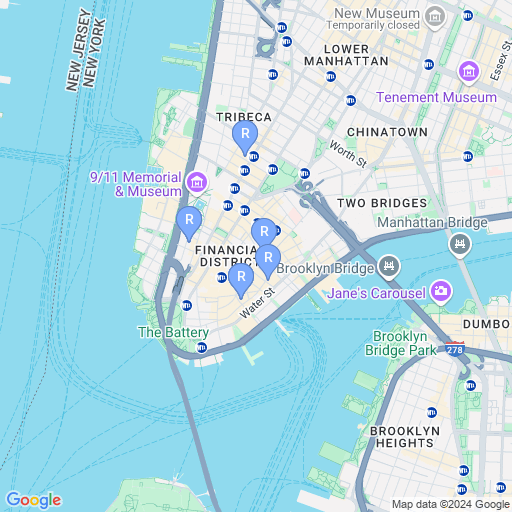

In [17]:
import java.net.URI
import javax.imageio.ImageIO
import dev.example.utils.*

val markers = narrowedDf.map {googleMapsMarker(
    label = TypeOfProperty,
    lat = Latitude,
    lon = Longitude)
}.joinToString("")

val url = "https://maps.google.com/maps/api/staticmap?center=Finance+District,New+York,NY&zoom=14&size=512x512&maptype=roadmap$markers&sensor=false&key=$googleMapsKey"
Image(ImageIO.read(URL(url).openStream())).withWidth(600)

### Figure out *WHEN*

In [18]:
import dev.example.utils.getDayPeriodAll

val result = narrowedDf.add("periodOfDay"){getDayPeriodAll(hourOfDay)}
    .groupBy("DayOfWeek", "periodOfDay")
    .aggregate { count() into "count" }

// Print the result
result.print()

    DayOfWeek         periodOfDay count
  0 WEDNESDAY       Evening-17_19     4
  1 WEDNESDAY Breakfast-Time-8_10     3
  2  THURSDAY   Early-Morning-5_7     1
  3  THURSDAY Breakfast-Time-8_10     4
  4    FRIDAY   Dinner-Time-20_20     1
  5    FRIDAY     Afternoon-14_16     1
  6    FRIDAY    Lunch-Time-11_13     2
  7  SATURDAY    Lunch-Time-11_13     2
  8    SUNDAY       Evening-17_19     1
  9    SUNDAY     Afternoon-14_16     2
 10    MONDAY       Evening-17_19     1
 11    MONDAY Breakfast-Time-8_10     2
 12    MONDAY    Lunch-Time-11_13     1
 13   TUESDAY Breakfast-Time-8_10     1
 14   TUESDAY    Lunch-Time-11_13     2
 15   TUESDAY         Night-21_23     1
 16 WEDNESDAY    Lunch-Time-11_13     1
 17  THURSDAY    Lunch-Time-11_13     2
 18    FRIDAY Breakfast-Time-8_10     1
 19    FRIDAY       Evening-17_19     1
...



In [19]:
result.plot {
    x(DayOfWeek) {
        axis {
            name = "Date of Week" // Axis label
        }
    }
    y(count) {
        axis.name = "Food Crimes Count"
    }

    bars {
        fillColor("periodOfDay") {
            legend {
                type = LegendType.DiscreteLegend()
                name = "Period of Day"
            }
        }
        //position = Position.stack()
    }
    layout.size = 1200 to 700
}

<head>
 <meta charset="UTF-8">
 <style> html, body { margin: 0; overflow: hidden; } </style>
 <script type="text/javascript" data-lets-plot-script="library" src="https://cdn.jsdelivr.net/gh/JetBrains/lets-plot@v4.3.3/js-package/distr/lets-plot.min.js"></script>
 </head>
 <body>
 <div id="ToaIbN"></div>
 <script type="text/javascript" data-lets-plot-script="plot">
 var plotSpec={
"mapping":{
},
"data":{
"DayOfWeek":["WEDNESDAY","WEDNESDAY","THURSDAY","THURSDAY","FRIDAY","FRIDAY","FRIDAY","SATURDAY","SUNDAY","SUNDAY","MONDAY","MONDAY","MONDAY","TUESDAY","TUESDAY","TUESDAY","WEDNESDAY","THURSDAY","FRIDAY","FRIDAY","SATURDAY","SATURDAY","SUNDAY","MONDAY","TUESDAY","THURSDAY"],
"count":[4.0,3.0,1.0,4.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
"periodOfDay":["Evening-17_19","Breakfast-Time-8_10","Early-Morning-5_7","Breakfast-Time-8_10","Dinner-Time-20_20","Afternoon-14_16","Lunch-Time-11_13","Lunch-Time-11_13","Evening-17_19","Afternoon-14_16","Evening-17_19","Breakfast-Time-8_10","Lunch-Time-11_13","Breakfast-Time-8_10","Lunch-Time-11_13","Night-21_23","Lunch-Time-11_13","Lunch-Time-11_13","Breakfast-Time-8_10","Evening-17_19","Breakfast-Time-8_10","Afternoon-14_16","Breakfast-Time-8_10","Afternoon-14_16","Dinner-Time-20_20","Evening-17_19"]
},
"ggsize":{
"width":1200.0,
"height":700.0
},
"kind":"plot",
"scales":[{
"aesthetic":"x",
"name":"Date of Week",
"limits":[null,null]
},{
"aesthetic":"y",
"name":"Food Crimes Count",
"limits":[null,null]
},{
"aesthetic":"fill",
"discrete":true,
"name":"Period of Day",
"guide":{
"name":"legend"
}
}],
"layers":[{
"mapping":{
"x":"DayOfWeek",
"y":"count",
"fill":"periodOfDay"
},
"stat":"identity",
"sampling":"none",
"position":"dodge",
"geom":"bar",
"data":{
}
}]
};
 var plotContainer = document.getElementById("ToaIbN");
 LetsPlot.buildPlotFromProcessedSpecs(plotSpec, -1, -1, plotContainer);
 </script>
 </body>
</html>"> 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 WEDNESDAY 
 
 
 
 
 
 
 
 
 THURSDAY 
 
 
 
 
 
 
 
 
 FRIDAY 
 
 
 
 
 
 
 
 
 SATURDAY 
 
 
 
 
 
 
 
 
 SUNDAY 
 
 
 
 
 
 
 
 
 MONDAY 
 
 
 
 
 
 
 
 
 TUESDAY 
 
 
 
 
 
 
 
 
 
 
 0.0 
 
 
 
 
 
 
 0.5 
 
 
 
 
 
 
 1.0 
 
 
 
 
 
 
 1.5 
 
 
 
 
 
 
 2.0 
 
 
 
 
 
 
 2.5 
 
 
 
 
 
 
 3.0 
 
 
 
 
 
 
 3.5 
 
 
 
 
 
 
 4.0 
 
 
 
 
 
 
 
 
 Food Crimes Count 
 
 
 
 
 Date of Week 
 
 
 
 
 
 
 
 
 Period of Day 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Evening-17_19 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Breakfast-Time-8_10 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Early-Morning-5_7 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Dinner-Time-20_20 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Afternoon-14_16 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Lunch-Time-11_13 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Night-21_23